Saving speech.wav to speech (1).wav


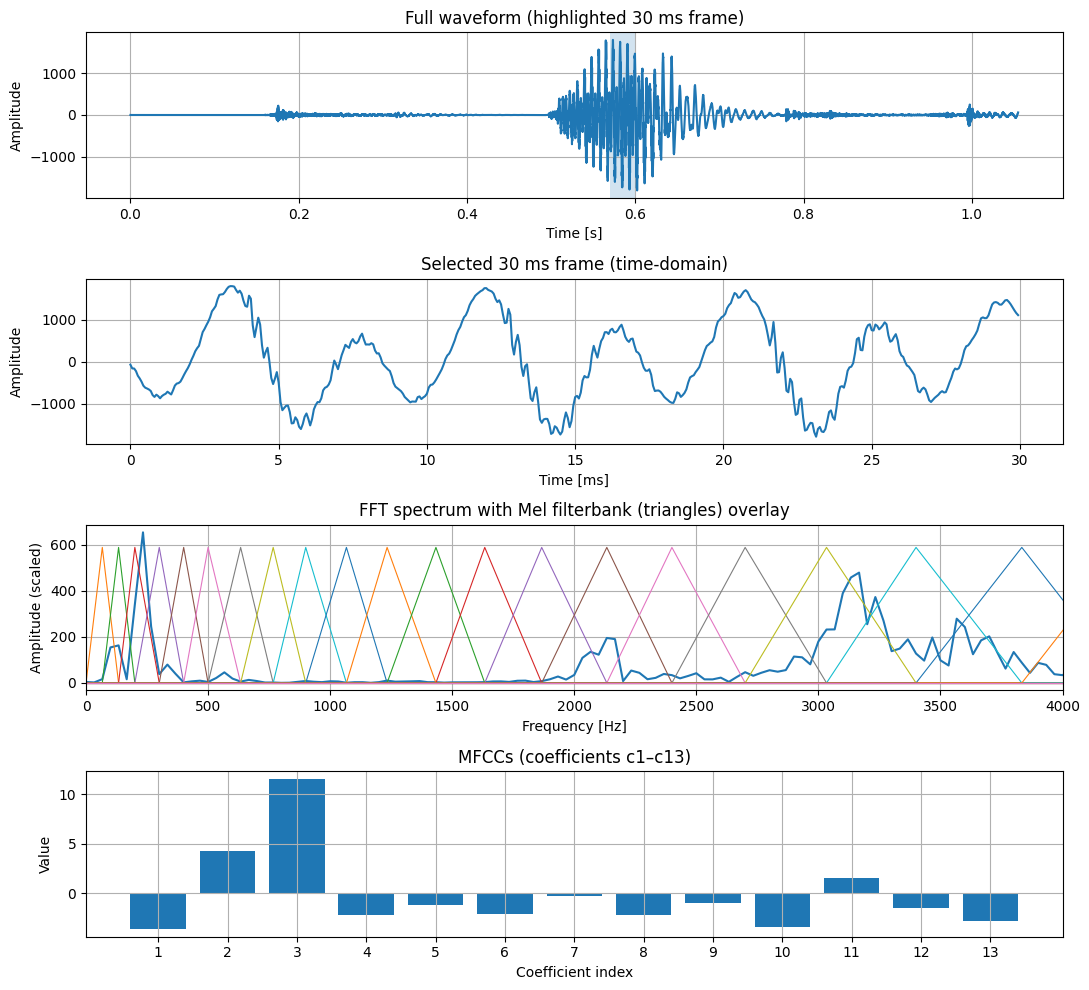

In [ ]:
# ============================
# Upload → FFT → Mel → MFCCs
# ============================
from google.colab import files
uploaded = files.upload()  # pick your speech.wav

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import dct

# ---------- Load WAV ----------
fname = list(uploaded.keys())[0]
fs, data = wavfile.read(fname)
x = data.astype(np.float32)
if x.ndim > 1:
    x = x[:,0]
# normalize to [-1, 1]
if x.dtype != np.float32:
    x = x / (np.max(np.abs(x)) + 1e-9)

# ---------- Helper: pick a voiced 30 ms frame ----------
frame_ms = 30
N = int(fs * frame_ms/1000.0)
hop = N//4  # stride for scanning
# RMS over sliding windows to find the most energetic frame
rms_vals = []
starts = range(0, max(1, len(x)-N), hop)
for s in starts:
    seg = x[s:s+N]
    if len(seg) < N: break
    rms_vals.append((s, np.sqrt(np.mean(seg**2))))
start_idx, _ = max(rms_vals, key=lambda t: t[1])
frame = x[start_idx:start_idx+N]

# ---------- Pre-emphasis + window ----------
alpha = 0.97
pre = np.append(frame[0], frame[1:] - alpha*frame[:-1])
win = np.hamming(N)
fw = pre * win

# ---------- FFT / spectrum ----------
# Power spectrum
fft_vals = np.fft.rfft(fw)
freqs = np.fft.rfftfreq(N, 1/fs)
power_spec = (1.0/N) * (np.abs(fft_vals) ** 2)

# ---------- Mel filterbank (no external libs) ----------
def hz_to_mel(f):  return 2595.0*np.log10(1.0 + f/700.0)
def mel_to_hz(m):  return 700.0*(10**(m/2595.0)-1.0)

n_mels = 26
fmin, fmax = 0.0, fs/2.0
mel_min, mel_max = hz_to_mel(fmin), hz_to_mel(fmax)
mel_points = np.linspace(mel_min, mel_max, n_mels+2)
hz_points  = mel_to_hz(mel_points)

bin_points = np.floor((N+1) * hz_points / fs).astype(int)
fbanks = np.zeros((n_mels, len(freqs)))
for m in range(1, n_mels+1):
    f_left, f_center, f_right = bin_points[m-1], bin_points[m], bin_points[m+1]
    if f_center == f_left:   f_center += 1
    if f_right  == f_center: f_right  += 1
    # Rising slope
    for k in range(f_left, f_center):
        fbanks[m-1, k] = (k - f_left) / (f_center - f_left + 1e-9)
    # Falling slope
    for k in range(f_center, f_right):
        fbanks[m-1, k] = (f_right - k) / (f_right - f_center + 1e-9)

# Filterbank energies (Mel bands)
mel_energies = np.dot(fbanks, power_spec + 1e-12)
log_mel = np.log(mel_energies)

# ---------- MFCCs (DCT of log-mel) ----------
# Keep first 13 coefficients (1..13), commonly skip c0 for robustness
mfccs = dct(log_mel, type=2, norm='ortho')
mfcc_13 = mfccs[1:14]

# ---------- Plot ----------
t = np.arange(len(x))/fs
t_frame = np.arange(N)/fs + start_idx/fs

plt.figure(figsize=(11, 10))

# (1) Full waveform with highlighted frame
ax1 = plt.subplot(4,1,1)
ax1.plot(t, x)
ax1.axvspan(start_idx/fs, (start_idx+N)/fs, alpha=0.2)
ax1.set_title("Full waveform (highlighted 30 ms frame)")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

# (2) Frame in time domain
ax2 = plt.subplot(4,1,2)
ax2.plot((np.arange(N)/fs)*1000, frame)
ax2.set_title("Selected 30 ms frame (time-domain)")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Amplitude")
ax2.grid(True)

# (3) FFT spectrum + Mel filterbank overlay
ax3 = plt.subplot(4,1,3)
ax3.plot(freqs, np.sqrt(power_spec))  # magnitude-like
for m in range(n_mels):
    # scale filters for visibility
    ax3.plot(freqs, fbanks[m]*np.max(np.sqrt(power_spec))*0.9, linewidth=0.8)
ax3.set_xlim(0, 4000)  # speech band
ax3.set_title("FFT spectrum with Mel filterbank (triangles) overlay")
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Amplitude (scaled)")
ax3.grid(True)

# (4) MFCC bar plot
ax4 = plt.subplot(4,1,4)
ax4.bar(np.arange(1, 14), mfcc_13)
ax4.set_xticks(np.arange(1, 14))
ax4.set_title("MFCCs (coefficients c1–c13)")
ax4.set_xlabel("Coefficient index")
ax4.set_ylabel("Value")
ax4.grid(True)

plt.tight_layout()
plt.show()


Sample rate: 16000 Hz
Samples: 16880
